In [1]:
# Libraries import
from datetime import datetime
from plotly.offline import init_notebook_mode
from googletrans import Translator

import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sn

import requests
import json

In [2]:
# Data import - 'Datos abiertos COVID-19 (Colombia)'
data = pd.DataFrame.from_dict(requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=9999999999999').json())
#data

In [3]:
# Data import - 'World Health Organization (WHO) COVID-19 Global Data'
who_data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
#who_data

In [4]:
# Data import - 'Colombia GeoJson'
geojson = requests.get('https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/be6a6e239cd5b5b803c6e7c2ec405b793a9064dd/Colombia.geo.json').json()
#geojson

In [5]:
# Data cleaning and adjusting
translator = Translator()
translations = {}

departments = {}
status_counts = []

data.columns = ['Id de caso', 'Fecha de notificación', 'Código DIVIPOLA', 'Ciudad de ubicación', 'Departamento', 'Estado', 'Edad', 'Sexo', 'Tipo', 'Severidad','País de procedencia', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web', 'Tipo de recuperación', 'Código departamento', 'Código país', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Fecha de defunción']
#who_data.columns = ['']

for element in data['País de procedencia'].unique():
    translations[element] = translator.translate(" ".join(element.split(" ")[:2])).text if type(element) !=  float else 'Colombia'

data['País de procedencia'].replace(translations, inplace=True)

for column in ['Edad', 'Código departamento']:
    data[column] = data[column].apply(lambda x: int(x))
    
data['Clasificación de edad'] = pd.cut(x=data['Edad'], bins=[0,10,20,30,40,50,60,70,80,90,np.inf], include_lowest=True, labels=['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 100+'])

for column in ['Ciudad de ubicación', 'Estado', 'Sexo', 'Tipo', 'Severidad', 'País de procedencia']:
    data[column] = data[column].str.capitalize()
    
for column in ['Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de defunción', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web']:
    data[column] = data[column].str.slice(0,10).replace(r'(\d+)-(\d+)-(\d+)', r'\1-\2-\3', regex=True).apply(lambda x: pd.to_datetime(x, dayfirst=True, errors='ignore'))

for element in geojson['features']:
    departments[int(element['properties']['DPTO'])] = element['properties']['NOMBRE_DPT']
    
status_counts = data['Estado'].value_counts().to_list()
    
data = data[['Id de caso', 'Fecha de reporte web', 'Fecha de diagnóstico', 'Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de recuperación', 'Fecha de defunción', 'Ciudad de ubicación', 'Departamento', 'Severidad', 'Estado', 'Edad', 'Clasificación de edad', 'Sexo', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Tipo', 'Tipo de recuperación', 'País de procedencia', 'Código departamento', 'Código país', 'Código DIVIPOLA']]
data = data.set_index('Id de caso')

In [6]:
# Data storage
date = data['Fecha de reporte web'].iloc[-1].strftime('%Y-%m-%d')
data.to_csv(f'./Datasets/COVID-19 Status (Colombia) [{date}].csv', index = True)

In [7]:
# Helper functions
def GetBars(df):
    d = df.to_dict('list')
    #for i in range(df[]):

def numbers(div): #x
    for i in range(0, len(ax.patches)//div, 1):
        height = 0
        for j in range(0, div, 1):
            height += ax.patches[j*(len(ax.patches)//div)+i].get_height()
        ax.text(ax.patches[i].get_x()+(ax.patches[i].get_width()/10),height+(height/100)+10, int(height), fontsize=7, color='dimgrey', rotation=90)

def numbers_H(div): #y
    for i in range(0, len(ax.patches)//div, 1):
        width = 0
        for j in range(0, div, 1):
            width += ax.patches[j*(len(ax.patches)//div)+i].get_width()
        ax.text(width+(width/100)+10,ax.patches[i].get_y()+(ax.patches[i].get_height()/10), int(width), fontsize=7, color='dimgrey', rotation=0)

In [8]:
# Testing
#bars = GetBars()

bar_chart = go.Figure(
    data = go.Histogram(
        
    ),
    layout = go.Layout(
        title="Casos confirmados VS Clasificación de Edad (Estado)",
        yaxis_title="Clasificación de edad",
        xaxis_title="Casos confirmados",
    )
)
#bar_chart.show()

#data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).to_dict('list')

In [9]:
# In-line plots libraries import
%matplotlib inline
init_notebook_mode(connected = True)

# COVID-19 Status (Colombia) 🇨🇴

#### Fuente: <a href='https://datos.gov.co'>Datos Abiertos - Colombia</a>

### - Panorama nacional COVID-19 (Colombia)

In [10]:
local_map = go.Figure(go.Choropleth(
    z=data['Código departamento'].value_counts().sort_index().tolist(),
    locations=[departments[key] for key in sorted(departments.keys())],
    featureidkey='properties.NOMBRE_DPT',
    geojson=geojson,
    colorscale='blues',
    colorbar_title="Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

local_map.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds='locations')

local_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

local_map.show()

### - Casos activos VS Departamento (Estado)

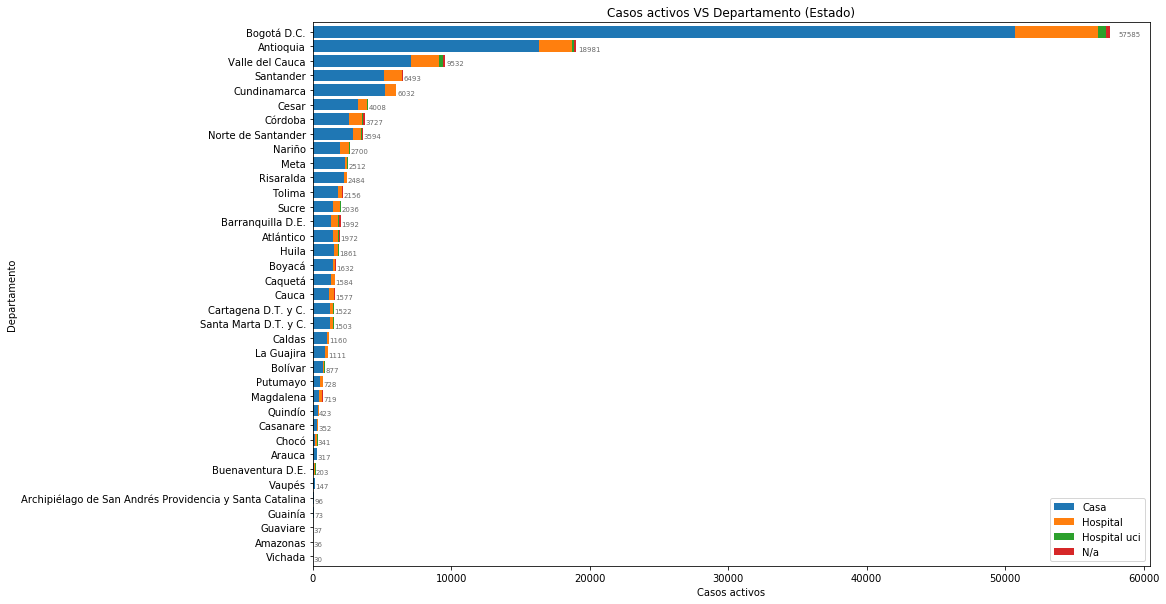

In [11]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos activos VS Departamento (Estado)'))
ax.set_xlabel('Casos activos')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [12]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Hospital  \
Departamento                                                            
Bogotá D.C.                                         50732.0    5976.0   
Antioquia                                           16344.0    2334.0   
Valle del Cauca                                      7060.0    2068.0   
Santander                                            5162.0    1240.0   
Cundinamarca                                         5170.0     805.0   
Cesar                                                3290.0     641.0   
Córdoba                                              2625.0     940.0   
Norte de Santander                                   2873.0     564.0   
Nariño                                               1967.0     654.0   
Meta                                                 2312.0     171.0   
Risaralda                                            2250.0     212.0   
Tolima                                               1822.0     284.0   
Sucre                                                1473.0     517.0   
Barranquilla D.E.                                    1336.0     505.0   
Atlántico                                            1451.0     369.0   
Huila                                                1527.0     313.0   
Boyacá                                               1441.0     163.0   
Caquetá                                              1281.0     280.0   
Cauca                                                1142.0     364.0   
Cartagena D.T. y C.                                  1248.0     196.0   
Santa Marta D.T. y C.                                1212.0     258.0   
Caldas                                               1010.0     126.0   
La Guajira                                            838.0     238.0   
Bolívar                                               693.0     139.0   
Putumayo                                              511.0     204.0   
Magdalena                                             451.0     206.0   
Quindío                                               388.0      32.0   
Casanare                                              298.0      47.0   
Chocó                                                 164.0     146.0   
Arauca                                                273.0      41.0   
Buenaventura D.E.                                      79.0     100.0   
Vaupés                                                141.0       6.0   
Archipiélago de San Andrés Providencia y Santa ...     86.0       9.0   
Guainía                                                72.0       1.0   
Guaviare                                               33.0       3.0   
Amazonas                                               24.0       7.0   
Vichada                                                29.0       1.0   

Estado                                              Hospital uci    N/a  \
Departamento                                                              
Bogotá D.C.                                                558.0  319.0   
Antioquia                                                  205.0   98.0   
Valle del Cauca                                            297.0  107.0   
Santander                                                   67.0   24.0   
Cundinamarca                                                27.0   30.0   
Cesar                                                       60.0   17.0   
Córdoba                                                     81.0   81.0   
Norte de Santander                                         137.0   20.0   
Nariño                                                      51.0   28.0   
Meta                                                        13.0   16.0   
Risaralda                                                   13.0    9.0   
Tolima                                                      25.0   25.0   
Sucre                                                       23.0   23.0   
Barranquilla D.E.          

### - Recuperados VS Departamento

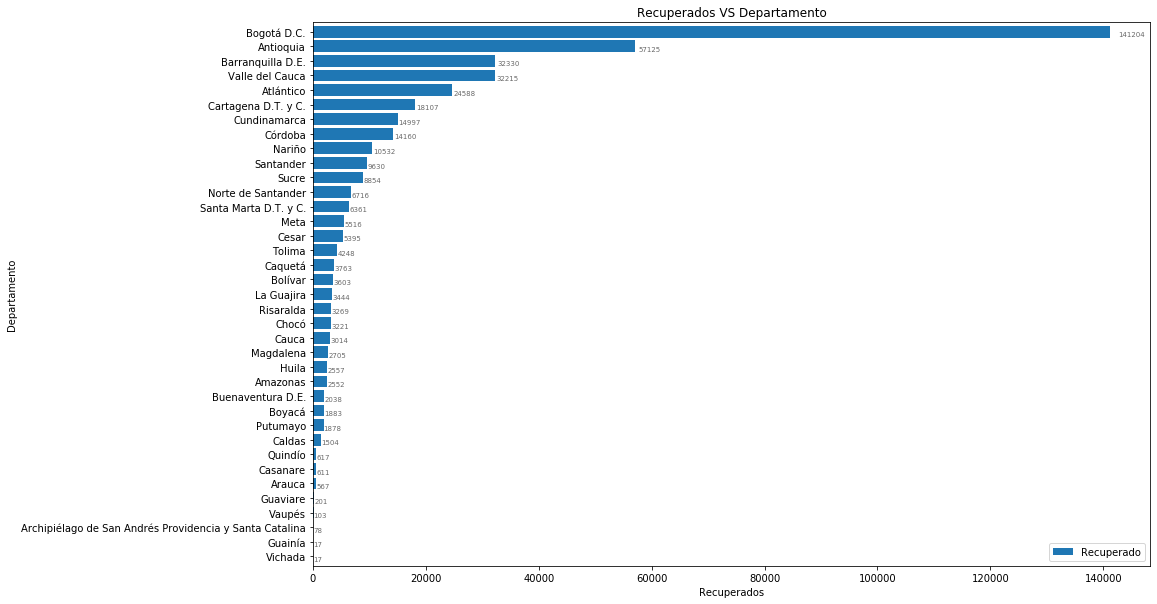

In [13]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, False, False, False, False, True]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Recuperados VS Departamento'))
ax.set_xlabel('Recuperados')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [14]:
li.sort_values('Total', ascending=False)

Estado                                              Recuperado     Total
Departamento                                                            
Bogotá D.C.                                           141204.0  141204.0
Antioquia                                              57125.0   57125.0
Barranquilla D.E.                                      32330.0   32330.0
Valle del Cauca                                        32215.0   32215.0
Atlántico                                              24588.0   24588.0
Cartagena D.T. y C.                                    18107.0   18107.0
Cundinamarca                                           14997.0   14997.0
Córdoba                                                14160.0   14160.0
Nariño                                                 10532.0   10532.0
Santander                                               9630.0    9630.0
Sucre                                                   8854.0    8854.0
Norte de Santander                                      6716.0    6716.0
Santa Marta D.T. y C.                                   6361.0    6361.0
Meta                                                    5516.0    5516.0
Cesar                                                   5395.0    5395.0
Tolima                                                  4248.0    4248.0
Caquetá                                                 3763.0    3763.0
Bolívar                                                 3603.0    3603.0
La Guajira                                              3444.0    3444.0
Risaralda                                               3269.0    3269.0
Chocó                                                   3221.0    3221.0
Cauca                                                   3014.0    3014.0
Magdalena                                               2705.0    2705.0
Huila                                                   2557.0    2557.0
Amazonas                                                2552.0    2552.0
Buenaventura D.E.                                       2038.0    2038.0
Boyacá                                                  1883.0    1883.0
Putumayo                                                1878.0    1878.0
Caldas                                                  1504.0    1504.0
Quindío                                                  617.0     617.0
Casanare                                                 611.0     611.0
Arauca                                                   567.0     567.0
Guaviare                                                 201.0     201.0
Vaupés                                                   103.0     103.0
Archipiélago de San Andrés Providencia y Santa ...        78.0      78.0
Guainía                                                   17.0      17.0
Vichada                                                   17.0      17.0

### - Fallecidos VS Departamento

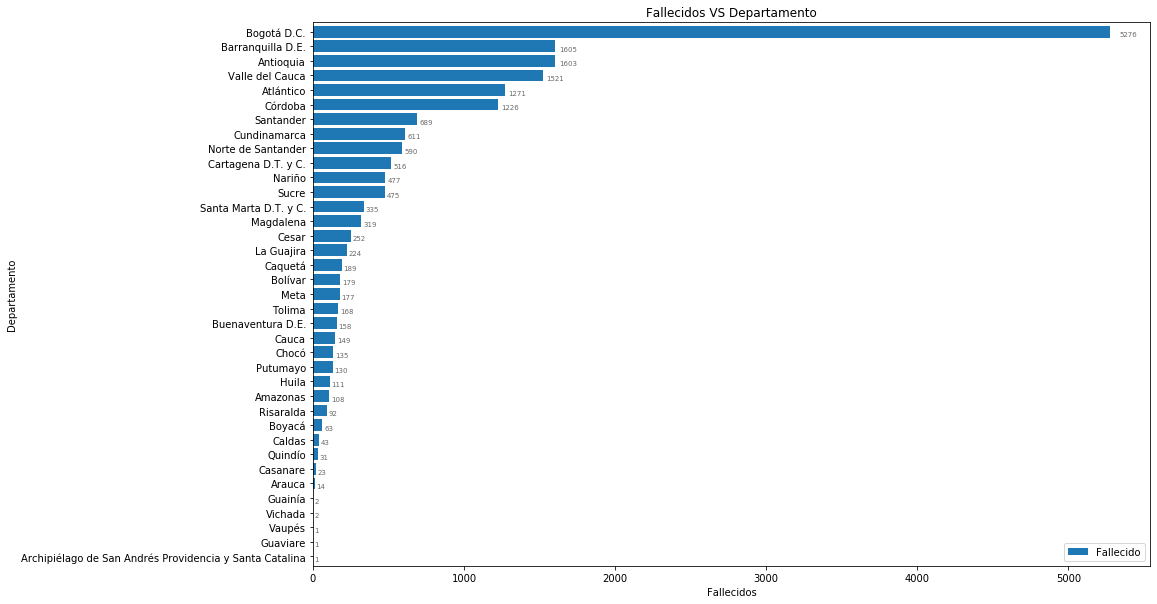

In [15]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, True, False, False, False, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Fallecidos VS Departamento'))
ax.set_xlabel('Fallecidos')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [16]:
li.sort_values('Total', ascending=False)

Estado                                              Fallecido   Total
Departamento                                                         
Bogotá D.C.                                            5276.0  5276.0
Barranquilla D.E.                                      1605.0  1605.0
Antioquia                                              1603.0  1603.0
Valle del Cauca                                        1521.0  1521.0
Atlántico                                              1271.0  1271.0
Córdoba                                                1226.0  1226.0
Santander                                               689.0   689.0
Cundinamarca                                            611.0   611.0
Norte de Santander                                      590.0   590.0
Cartagena D.T. y C.                                     516.0   516.0
Nariño                                                  477.0   477.0
Sucre                                                   475.0   475.0
Santa Marta D.T. y C.                                   335.0   335.0
Magdalena                                               319.0   319.0
Cesar                                                   252.0   252.0
La Guajira                                              224.0   224.0
Caquetá                                                 189.0   189.0
Bolívar                                                 179.0   179.0
Meta                                                    177.0   177.0
Tolima                                                  168.0   168.0
Buenaventura D.E.                                       158.0   158.0
Cauca                                                   149.0   149.0
Chocó                                                   135.0   135.0
Putumayo                                                130.0   130.0
Huila                                                   111.0   111.0
Amazonas                                                108.0   108.0
Risaralda                                                92.0    92.0
Boyacá                                                   63.0    63.0
Caldas                                                   43.0    43.0
Quindío                                                  31.0    31.0
Casanare                                                 23.0    23.0
Arauca                                                   14.0    14.0
Guainía                                                   2.0     2.0
Vichada                                                   2.0     2.0
Guaviare                                                  1.0     1.0
Archipiélago de San Andrés Providencia y Santa ...        1.0     1.0
Vaupés                                                    1.0     1.0

* Fallecimientos relacionados al COVID-19.

### - Casos confirmados VS Departamento (Estado)

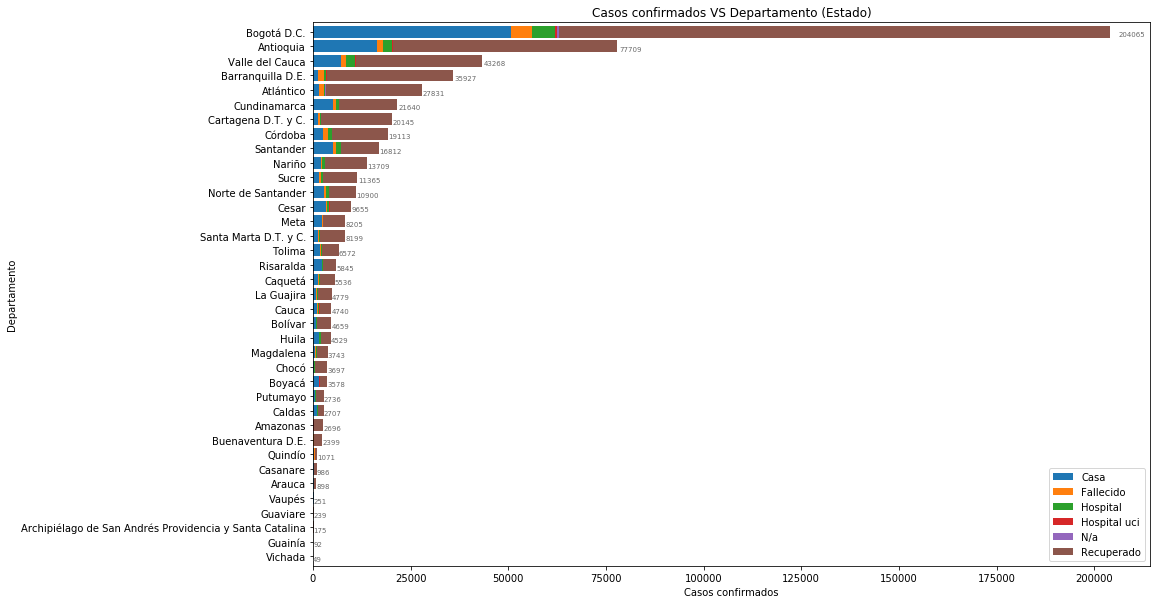

In [17]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [18]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Fallecido  \
Departamento                                                             
Bogotá D.C.                                         50732.0     5276.0   
Antioquia                                           16344.0     1603.0   
Valle del Cauca                                      7060.0     1521.0   
Barranquilla D.E.                                    1336.0     1605.0   
Atlántico                                            1451.0     1271.0   
Cundinamarca                                         5170.0      611.0   
Cartagena D.T. y C.                                  1248.0      516.0   
Córdoba                                              2625.0     1226.0   
Santander                                            5162.0      689.0   
Nariño                                               1967.0      477.0   
Sucre                                                1473.0      475.0   
Norte de Santander                                   2873.0      590.0   
Cesar                                                3290.0      252.0   
Meta                                                 2312.0      177.0   
Santa Marta D.T. y C.                                1212.0      335.0   
Tolima                                               1822.0      168.0   
Risaralda                                            2250.0       92.0   
Caquetá                                              1281.0      189.0   
La Guajira                                            838.0      224.0   
Cauca                                                1142.0      149.0   
Bolívar                                               693.0      179.0   
Huila                                                1527.0      111.0   
Magdalena                                             451.0      319.0   
Chocó                                                 164.0      135.0   
Boyacá                                               1441.0       63.0   
Putumayo                                              511.0      130.0   
Caldas                                               1010.0       43.0   
Amazonas                                               24.0      108.0   
Buenaventura D.E.                                      79.0      158.0   
Quindío                                               388.0       31.0   
Casanare                                              298.0       23.0   
Arauca                                                273.0       14.0   
Vaupés                                                141.0        1.0   
Guaviare                                               33.0        1.0   
Archipiélago de San Andrés Providencia y Santa ...     86.0        1.0   
Guainía                                                72.0        2.0   
Vichada                                                29.0        2.0   

Estado                                              Hospital  Hospital uci  \
Departamento                                                                 
Bogotá D.C.                                           5976.0         558.0   
Antioquia                                             2334.0         205.0   
Valle del Cauca                                       2068.0         297.0   
Barranquilla D.E.                                      505.0          51.0   
Atlántico                                              369.0          61.0   
Cundinamarca                                           805.0          27.0   
Cartagena D.T. y C.                                    196.0          44.0   
Córdoba                                                940.0          81.0   
Santander                                             1240.0          67.0   
Nariño                                                 654.0          51.0   
Sucre                                                  517.0          23.0   
Norte de Santander                                     564.0         137.0   
Cesar                

### - Casos confirmados VS Departamento (Sexo)

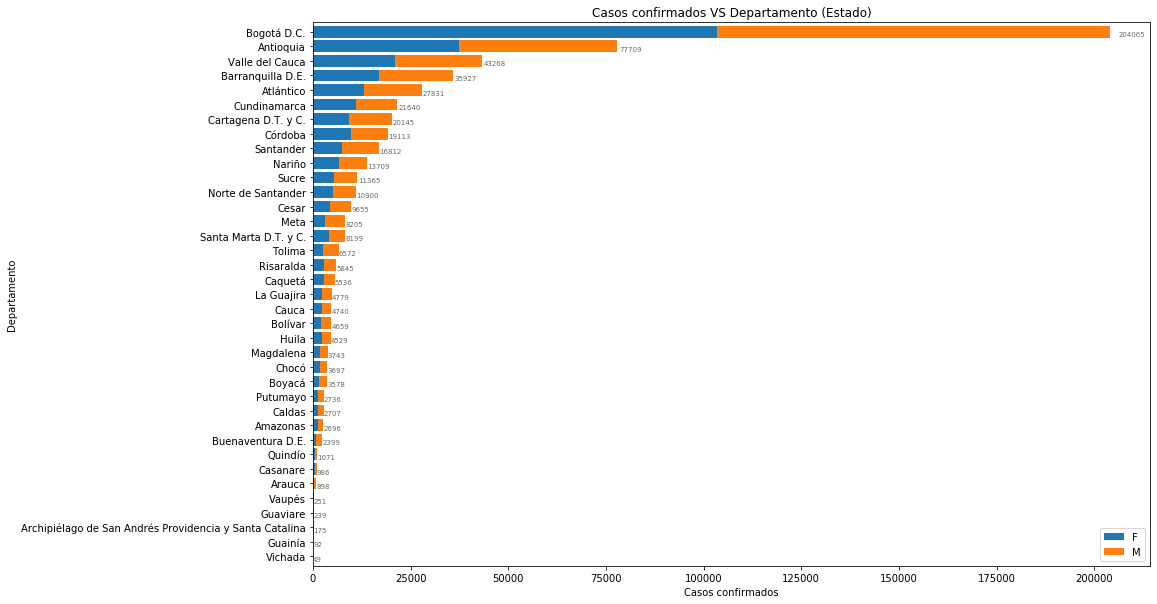

In [19]:
li = data.groupby(['Departamento', 'Sexo']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [20]:
li.sort_values('Total', ascending=False)

Sexo                                                     F       M   Total
Departamento                                                              
Bogotá D.C.                                         103344  100721  204065
Antioquia                                            37354   40355   77709
Valle del Cauca                                      20950   22318   43268
Barranquilla D.E.                                    16940   18987   35927
Atlántico                                            13194   14637   27831
Cundinamarca                                         10972   10668   21640
Cartagena D.T. y C.                                   9265   10880   20145
Córdoba                                               9822    9291   19113
Santander                                             7317    9495   16812
Nariño                                                6576    7133   13709
Sucre                                                 5477    5888   11365
Norte de Santander                                    5023    5877   10900
Cesar                                                 4471    5184    9655
Meta                                                  3082    5123    8205
Santa Marta D.T. y C.                                 4125    4074    8199
Tolima                                                2603    3969    6572
Risaralda                                             2807    3038    5845
Caquetá                                               2741    2795    5536
La Guajira                                            2412    2367    4779
Cauca                                                 2213    2527    4740
Bolívar                                               2171    2488    4659
Huila                                                 2249    2280    4529
Magdalena                                             1897    1846    3743
Chocó                                                 1754    1943    3697
Boyacá                                                1654    1924    3578
Putumayo                                              1234    1502    2736
Caldas                                                1296    1411    2707
Amazonas                                              1166    1530    2696
Buenaventura D.E.                                      897    1502    2399
Quindío                                                533     538    1071
Casanare                                               411     575     986
Arauca                                                 296     602     898
Vaupés                                                 113     138     251
Guaviare                                                35     204     239
Archipiélago de San Andrés Providencia y Santa ...      99      76     175
Guainía                                                 39      53      92
Vichada                                                 13      36      49

### - Dataset COVID-19 (Colombia)

In [21]:
data

Fecha de reporte web Fecha de diagnóstico Fecha de notificación  \
Id de caso                                                                   
1                    2020-03-06           2020-03-06            2020-03-02   
2                    2020-03-09           2020-03-09            2020-03-06   
3                    2020-03-09           2020-03-09            2020-03-07   
4                    2020-03-11           2020-03-11            2020-03-09   
5                    2020-03-11           2020-03-11            2020-03-09   
...                         ...                  ...                   ...   
590556               2020-08-28           2020-08-24            2020-08-13   
590557               2020-08-28           2020-08-12            2020-08-01   
590558               2020-08-28           2020-08-10            2020-07-30   
590559               2020-08-28           2020-08-25            2020-08-14   
590560               2020-08-28           2020-08-13            2020-08-02   

           Fecha de inicio de síntomas Fecha de recuperación  \
Id de caso                                                     
1                  2020-02-27 00:00:00            2020-03-13   
2                  2020-03-04 00:00:00            2020-03-19   
3                  2020-02-29 00:00:00            2020-03-15   
4                  2020-03-06 00:00:00            2020-03-26   
5                  2020-03-08 00:00:00            2020-03-23   
...                                ...                   ...   
590556             2020-08-09 00:00:00                   NaT   
590557             2020-07-28 00:00:00                   NaT   
590558             2020-07-26 00:00:00                   NaT   
590559             2020-08-10 00:00:00                   NaT   
590560             2020-07-29 00:00:00                   NaT   

           Fecha de defunción  Ciudad de ubicación     Departamento Severidad  \
Id de caso                                                                      
1                         NaT          Bogotá d.c.      Bogotá D.C.      Leve   
2                         NaT  Guadalajara de buga  Valle del Cauca      Leve   
3                         NaT             Medellín        Antioquia      Leve   
4                         NaT             Medellín        Antioquia      Leve   
5                         NaT             Medellín        Antioquia      Leve   
...                       ...                  ...              ...       ...   
590556                    NaT             Medellín        Antioquia      Leve   
590557                    NaT             Medellín        Antioquia      Leve   
590558                    NaT             Medellín        Antioquia      Leve   
590559                    NaT             Medellín        Antioquia      Leve   
590560                    NaT             Medellín        Antioquia      Leve   

                Estado  ...  Clasificación de edad Sexo Pertenecia Étnica  \
Id de caso              ...                                                 
1           Recuperado  ...                10 - 20    F              Otro   
2           Recuperado  ...                30 - 40    M              Otro   
3           Recuperado  ...                40 - 50    F              Otro   
4           Recuperado  ...                50 - 60    M              Otro   
5           Recuperado  ...                20 - 30    M              Otro   
...                ...  ...                    ...  ...               ...   
590556            Casa  ...                10 - 20    M               NaN   
590557            Casa  ...                10 - 20    M               NaN   
590558            Casa  ...                10 - 20    F               NaN   
590559            Casa  ...                10 - 20    F               NaN   
590560            Casa  ...                10 - 20    M               NaN   

           Nombre Grupo Étnico         Tipo Tipo de recuperación  \
Id de caso                             

### - Mapa de influencia COVID-19 (Colombia)

In [22]:
global_map = go.Figure(data = go.Choropleth(
    z = data['País de procedencia'].value_counts().sort_index().tolist(),
    locations = sorted(data['País de procedencia'].unique().tolist()),
    locationmode = 'country names',
    colorscale = 'greens',
    colorbar_title = "Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

global_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

global_map.show()

### - Casos confirmados acumulado VS Fecha de diagnóstico (Estado)

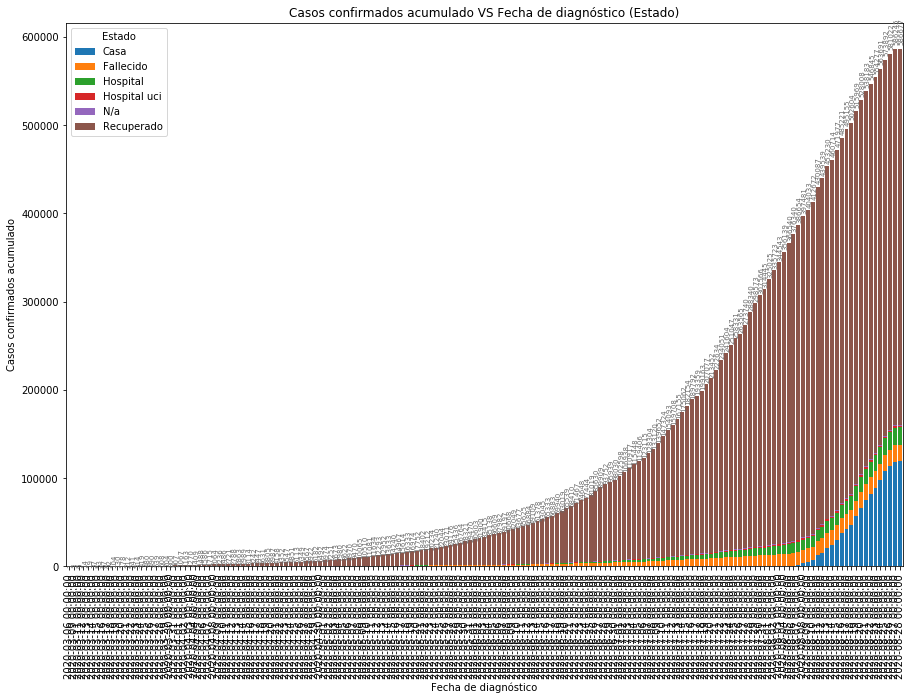

In [23]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Estado'].unique())
numbers(div)

In [24]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Estado                    Casa  Fallecido  Hospital  Hospital uci     N/a  \
Fecha de diagnóstico                                                        
2020-08-28            118803.0    18563.0   20076.0        1945.0  1183.0   
2020-08-27            118414.0    18563.0   20041.0        1937.0  1183.0   
2020-08-26            113725.0    18562.0   19569.0        1921.0  1183.0   
2020-08-25            107450.0    18502.0   19052.0        1900.0  1182.0   
2020-08-24             97917.0    18425.0   18597.0        1899.0  1179.0   
2020-08-23             89275.0    18314.0   18132.0        1889.0  1173.0   
2020-08-22             82440.0    18230.0   17813.0        1886.0  1171.0   
2020-08-21             74761.0    18093.0   17347.0        1879.0  1166.0   
2020-08-20             66278.0    17934.0   16858.0        1840.0  1155.0   
2020-08-19             56764.0    17670.0   16157.0        1776.0  1144.0   
2020-08-18             46308.0    17462.0   15606.0        1755.0  1131.0   
2020-08-17             42049.0    17274.0   15223.0        1745.0  1112.0   
2020-08-16             37228.0    17138.0   14890.0        1733.0  1105.0   
2020-08-15             29574.0    16895.0   14447.0        1721.0  1098.0   
2020-08-14             23996.0    16651.0   13987.0        1704.0  1091.0   
2020-08-13             21266.0    16443.0   13667.0        1690.0  1083.0   
2020-08-12             15360.0    16175.0   13173.0        1671.0  1069.0   
2020-08-11             12612.0    15861.0   12712.0        1647.0  1058.0   
2020-08-10              6794.0    15484.0   12058.0        1596.0  1041.0   
2020-08-09              5060.0    15272.0   11714.0        1577.0  1024.0   
2020-08-08              3757.0    15063.0   11393.0        1557.0  1017.0   
2020-08-07              1858.0    14766.0   11096.0        1524.0  1003.0   
2020-08-06               679.0    14501.0   10760.0        1478.0   986.0   
2020-08-05               255.0    14228.0   10488.0        1434.0   966.0   
2020-08-04               101.0    13952.0   10148.0        1390.0   944.0   
2020-08-03                49.0    13641.0    9834.0        1349.0   929.0   
2020-08-02                45.0    13316.0    9462.0        1312.0   912.0   
2020-08-01                44.0    12964.0    9071.0        1273.0   898.0   
2020-07-31                38.0    12627.0    8624.0        1239.0   878.0   
2020-07-30                36.0    12392.0    8371.0        1220.0   863.0   
2020-07-29                33.0    12105.0    8098.0        1176.0   843.0   
2020-07-28                26.0    11815.0    7769.0        1132.0   821.0   
2020-07-27                25.0    11270.0    7279.0        1078.0   784.0   
2020-07-26                22.0    10951.0    6989.0        1042.0   762.0   
2020-07-25                20.0    10712.0    6799.0        1017.0   750.0   
2020-07-24                18.0    10414.0    6496.0         982.0   735.0   
2020-07-23                16.0    10116.0    6222.0         950.0   714.0   
2020-07-22                14.0     9745.0    5882.0         911.0   686.0   
2020-07-21                12.0     9304.0    5466.0         857.0   659.0   
2020-07-20                10.0     8961.0    5208.0         806.0   644.0   
2020-07-19                10.0     8692.0    4930.0         778.0   632.0   
2020-07-18                10.0     8415.0    4716.0         754.0   615.0   
2020-07-17                10.0     8177.0    4544.0         726.0   593.0   
2020-07-16                 9.0     8001.0    4441.0         712.0   584.0   
2020-07-15                 9.0     7717.0    4187.0         674.0   564.0   
2020-07-14                 9.0     7422.0    3984.0         641.0   553.0   
2020-07-13                 8.0     7138.0    3764.0         613.0   528.0   
2020-07-12                 8.0     6871.0    3530.0         582.0   507.0   
2020-07-11                 8.0     6659.0    3379.0         554.0   493.0   
2020-07-10                 8.0     6399.0    3171.0         535.0   466.0

### - Casos confirmados VS Fecha de diagnóstico (Estado)

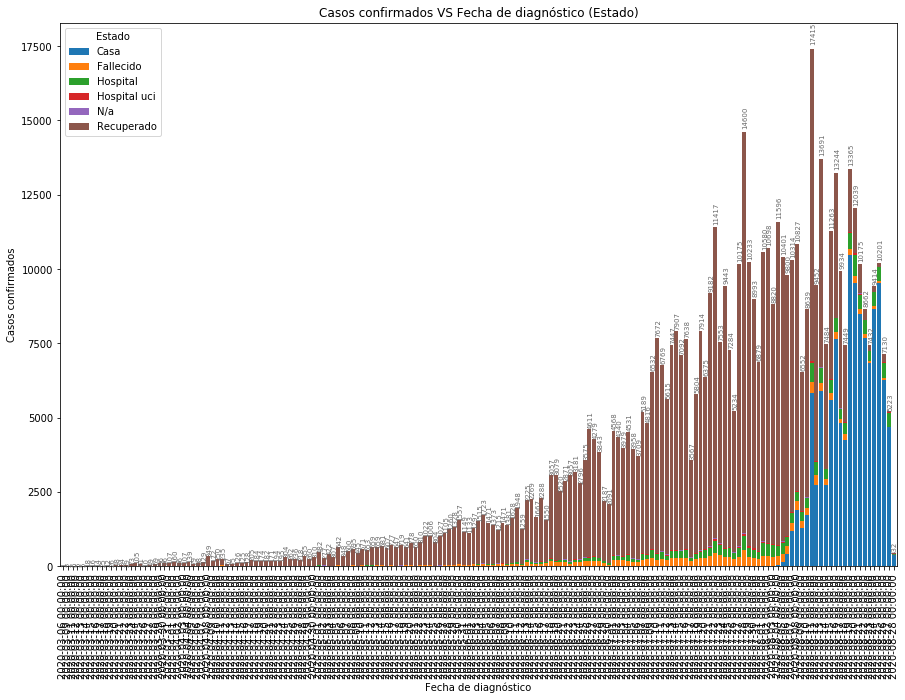

In [25]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers(div)

In [26]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).tail(60)[::-1]

Estado                   Casa  Fallecido  Hospital  Hospital uci   N/a  \
Fecha de diagnóstico                                                     
2020-08-28              389.0        0.0      35.0           8.0   0.0   
2020-08-27             4689.0        1.0     472.0          16.0   0.0   
2020-08-26             6275.0       60.0     517.0          21.0   1.0   
2020-08-25             9533.0       77.0     455.0           1.0   3.0   
2020-08-24             8642.0      111.0     465.0          10.0   6.0   
2020-08-23             6835.0       84.0     319.0           3.0   2.0   
2020-08-22             7679.0      137.0     466.0           7.0   5.0   
2020-08-21             8483.0      159.0     489.0          39.0  11.0   
2020-08-20             9514.0      264.0     701.0          64.0  11.0   
2020-08-19            10456.0      208.0     551.0          21.0  13.0   
2020-08-18             4259.0      188.0     383.0          10.0  19.0   
2020-08-17             4821.0      136.0     333.0          12.0   7.0   
2020-08-16             7654.0      243.0     443.0          12.0   7.0   
2020-08-15             5578.0      244.0     460.0          17.0   7.0   
2020-08-14             2730.0      208.0     320.0          14.0   8.0   
2020-08-13             5906.0      268.0     494.0          19.0  14.0   
2020-08-12             2748.0      314.0     461.0          24.0  11.0   
2020-08-11             5818.0      377.0     654.0          51.0  17.0   
2020-08-10             1734.0      212.0     344.0          19.0  17.0   
2020-08-09             1303.0      209.0     321.0          20.0   7.0   
2020-08-08             1899.0      297.0     297.0          33.0  14.0   
2020-08-07             1179.0      265.0     336.0          46.0  17.0   
2020-08-06              424.0      273.0     272.0          44.0  20.0   
2020-08-05              154.0      276.0     340.0          44.0  22.0   
2020-08-04               52.0      311.0     314.0          41.0  15.0   
2020-08-03                4.0      325.0     372.0          37.0  17.0   
2020-08-02                1.0      352.0     391.0          39.0  14.0   
2020-08-01                6.0      337.0     447.0          34.0  20.0   
2020-07-31                2.0      235.0     253.0          19.0  15.0   
2020-07-30                3.0      287.0     273.0          44.0  20.0   
2020-07-29                7.0      290.0     329.0          44.0  22.0   
2020-07-28                1.0      545.0     490.0          54.0  37.0   
2020-07-27                3.0      319.0     290.0          36.0  22.0   
2020-07-26                2.0      239.0     190.0          25.0  12.0   
2020-07-25                2.0      298.0     303.0          35.0  15.0   
2020-07-24                2.0      298.0     274.0          32.0  21.0   
2020-07-23                2.0      371.0     340.0          39.0  28.0   
2020-07-22                2.0      441.0     416.0          54.0  27.0   
2020-07-21                2.0      343.0     258.0          51.0  15.0   
2020-07-20                0.0      269.0     278.0          28.0  12.0   
2020-07-19                0.0      277.0     214.0          24.0  17.0   
2020-07-18                0.0      238.0     172.0          28.0  22.0   
2020-07-17                1.0      176.0     103.0          14.0   9.0   
2020-07-16                0.0      284.0     254.0          38.0  20.0   
2020-07-15                0.0      295.0     203.0          33.0  11.0   
2020-07-14                1.0      284.0     220.0          28.0  25.0   
2020-07-13                0.0      267.0     234.0          31.0  21.0   
2020-07-12                0.0      212.0     151.0          28.0  14.0   
2020-07-11                0.0      260.0     208.0          19.0  27.0   
2020-07-10                1.0      219.0     192.0          28.0  18.0   
2020-07-09                0.0      293.0     246.0          43.0  11.0   
2020-07-08                0.0      242.0     137.0          22.0   9.0   
2020

### - Casos confirmados VS Clasificación de edad (Estado)

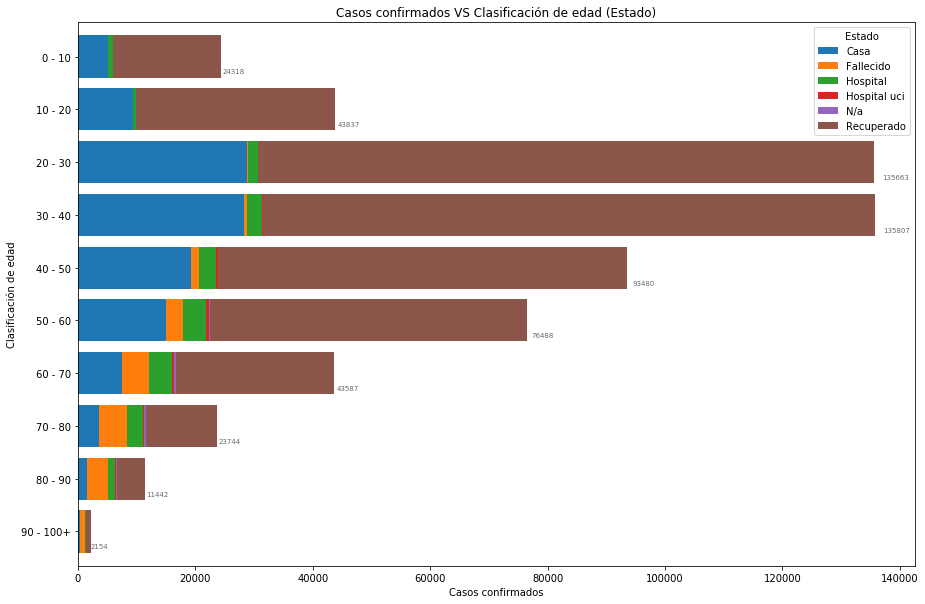

In [27]:
ax = data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Estado)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers_H(div)

In [28]:
data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0)

Estado                  Casa  Fallecido  Hospital  Hospital uci  N/a  \
Clasificación de edad                                                  
0 - 10                  5051         32       854            47   30   
10 - 20                 9383         30       426            29   20   
20 - 30                28738        244      1638            84   53   
30 - 40                28253        616      2410           190   43   
40 - 50                19273       1368      2849           296   91   
50 - 60                14986       2832      4079           486  145   
60 - 70                 7568       4540      3839           455  249   
70 - 80                 3637       4781      2617           288  282   
80 - 90                 1591       3524      1262            76  235   
90 - 100+                328        800       186             7   59   

Estado                 Recuperado  
Clasificación de edad              
0 - 10                      18304  
10 - 20                     33949  
20 - 30                    104906  
30 - 40                    104295  
40 - 50                     69603  
50 - 60                     53960  
60 - 70                     26936  
70 - 80                     12139  
80 - 90                      4754  
90 - 100+                     774

### - Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)

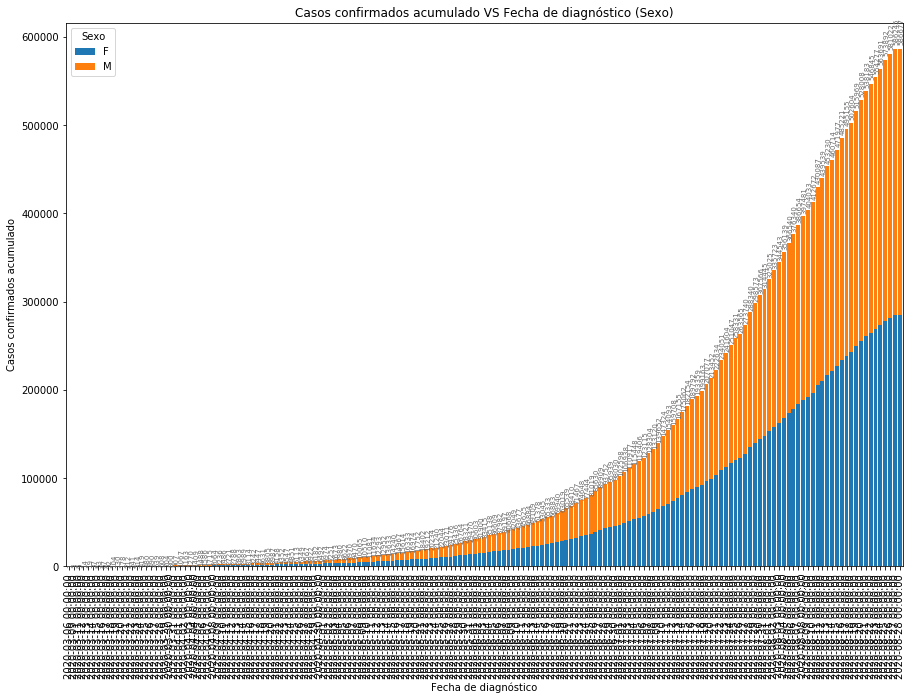

In [29]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Sexo'].unique())
numbers(div)

In [30]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Sexo                         F         M
Fecha de diagnóstico                    
2020-08-28            284727.0  301950.0
2020-08-27            284507.0  301738.0
2020-08-26            281847.0  299175.0
2020-08-25            278208.0  295684.0
2020-08-24            273080.0  290611.0
2020-08-23            268365.0  285912.0
2020-08-22            264584.0  282261.0
2020-08-21            260492.0  277691.0
2020-08-20            255359.0  272649.0
2020-08-19            249294.0  266675.0
2020-08-18            242358.0  260246.0
2020-08-17            238768.0  256387.0
2020-08-16            233522.0  251699.0
2020-08-15            226602.0  245375.0
2020-08-14            220879.0  239835.0
2020-08-13            217053.0  236177.0
2020-08-12            210199.0  229340.0
2020-08-11            205520.0  224567.0
2020-08-10            196494.0  216178.0
2020-08-09            192157.0  211876.0
2020-08-08            188779.0  208702.0
2020-08-07            183508.0  203146.0
2020-08-06            178469.0  197871.0
2020-08-05            173617.0  192923.0
2020-08-04            168408.0  187731.0
2020-08-03            162595.0  181948.0
2020-08-02            158327.0  177396.0
2020-08-01            152857.0  172168.0
2020-07-31            147738.0  166707.0
2020-07-30            144289.0  163277.0
2020-07-29            139916.0  158657.0
2020-07-28            134837.0  153503.0
2020-07-27            127726.0  146014.0
2020-07-26            122850.0  140715.0
2020-07-25            120451.0  137880.0
2020-07-24            116764.0  134283.0
2020-07-23            112398.0  129206.0
2020-07-22            108829.0  125222.0
2020-07-21            103666.0  118968.0
2020-07-20             99364.0  114088.0
2020-07-19             96388.0  110689.0
2020-07-18             92598.0  106565.0
2020-07-17             89817.0  103542.0
2020-07-16             88060.0  101732.0
2020-07-15             84311.0   97843.0
2020-07-14             80942.0   94120.0
2020-07-13             77346.0   89809.0
2020-07-12             73777.0   85931.0
2020-07-11             71103.0   82990.0
2020-07-10             67889.0   79435.0
2020-07-09             64384.0   75268.0
2020-07-08             61419.0   71701.0
2020-07-07             59109.0   69195.0
2020-07-06             56700.0   66415.0
2020-07-05             54947.0   64459.0
2020-07-04             53113.0   62335.0
2020-07-03             51084.0   59833.0
2020-07-02             49228.0   57710.0
2020-07-01             47200.0   55398.0
2020-06-30             45125.0   52905.0

### - Casos confirmados VS Fecha de diagnóstico (Sexo)

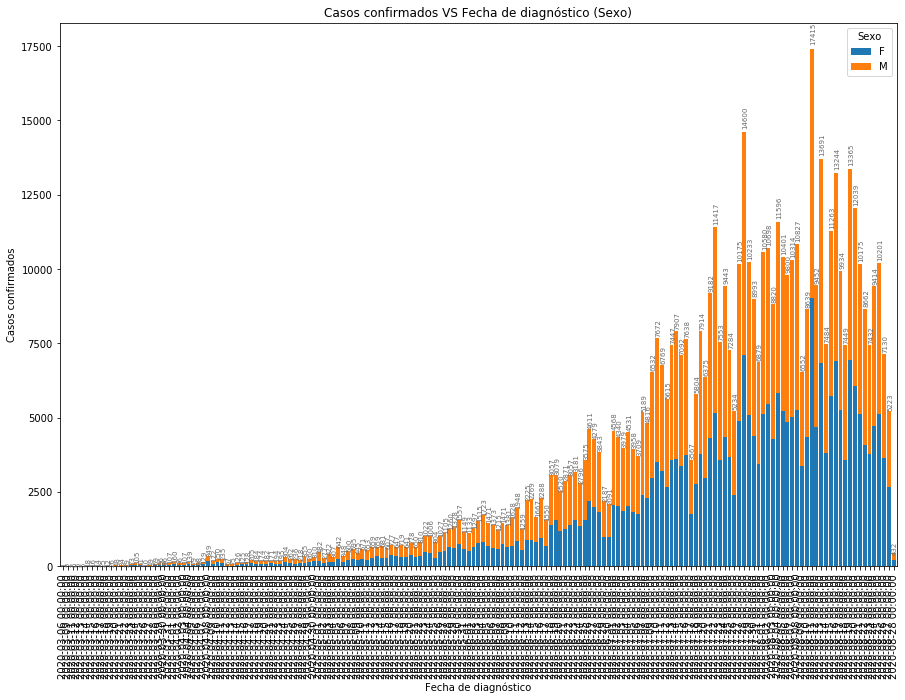

In [31]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers(div)

In [32]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).tail(60)[::-1]

Sexo                       F       M
Fecha de diagnóstico                
2020-08-28             220.0   212.0
2020-08-27            2660.0  2563.0
2020-08-26            3639.0  3491.0
2020-08-25            5128.0  5073.0
2020-08-24            4715.0  4699.0
2020-08-23            3781.0  3651.0
2020-08-22            4092.0  4570.0
2020-08-21            5133.0  5042.0
2020-08-20            6065.0  5974.0
2020-08-19            6936.0  6429.0
2020-08-18            3590.0  3859.0
2020-08-17            5246.0  4688.0
2020-08-16            6920.0  6324.0
2020-08-15            5723.0  5540.0
2020-08-14            3826.0  3658.0
2020-08-13            6854.0  6837.0
2020-08-12            4679.0  4773.0
2020-08-11            9026.0  8389.0
2020-08-10            4337.0  4302.0
2020-08-09            3378.0  3174.0
2020-08-08            5271.0  5556.0
2020-08-07            5039.0  5275.0
2020-08-06            4852.0  4948.0
2020-08-05            5209.0  5192.0
2020-08-04            5813.0  5783.0
2020-08-03            4268.0  4552.0
2020-08-02            5470.0  5228.0
2020-08-01            5119.0  5461.0
2020-07-31            3449.0  3430.0
2020-07-30            4373.0  4620.0
2020-07-29            5079.0  5154.0
2020-07-28            7111.0  7489.0
2020-07-27            4876.0  5299.0
2020-07-26            2399.0  2835.0
2020-07-25            3687.0  3597.0
2020-07-24            4366.0  5077.0
2020-07-23            3569.0  3984.0
2020-07-22            5163.0  6254.0
2020-07-21            4302.0  4880.0
2020-07-20            2976.0  3399.0
2020-07-19            3790.0  4124.0
2020-07-18            2781.0  3023.0
2020-07-17            1757.0  1810.0
2020-07-16            3749.0  3889.0
2020-07-15            3369.0  3723.0
2020-07-14            3596.0  4311.0
2020-07-13            3569.0  3878.0
2020-07-12            2674.0  2941.0
2020-07-11            3214.0  3555.0
2020-07-10            3505.0  4167.0
2020-07-09            2965.0  3567.0
2020-07-08            2310.0  2506.0
2020-07-07            2409.0  2780.0
2020-07-06            1753.0  1956.0
2020-07-05            1834.0  2124.0
2020-07-04            2029.0  2502.0
2020-07-03            1856.0  2123.0
2020-07-02            2028.0  2312.0
2020-07-01            2075.0  2493.0
2020-06-30             973.0  1118.0

### - Casos confirmados VS Clasificación de edad (Sexo)

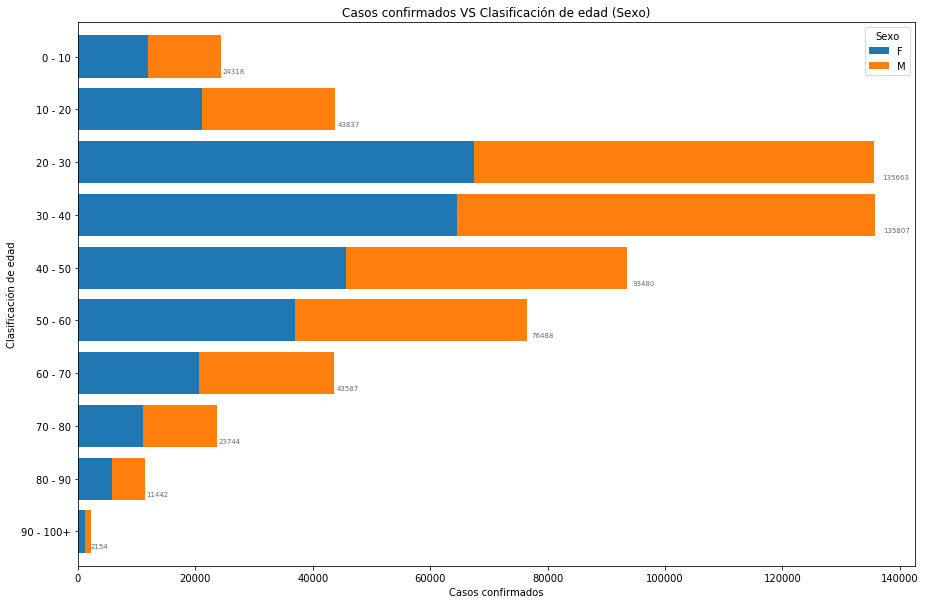

In [33]:
ax = data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [34]:
data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0)

Sexo                       F      M
Clasificación de edad              
0 - 10                 11905  12413
10 - 20                21081  22756
20 - 30                67501  68162
30 - 40                64597  71210
40 - 50                45662  47818
50 - 60                37008  39480
60 - 70                20667  22920
70 - 80                11082  12662
80 - 90                 5815   5627
90 - 100+               1227    927

### - Casos confirmados VS Estado (Sexo)

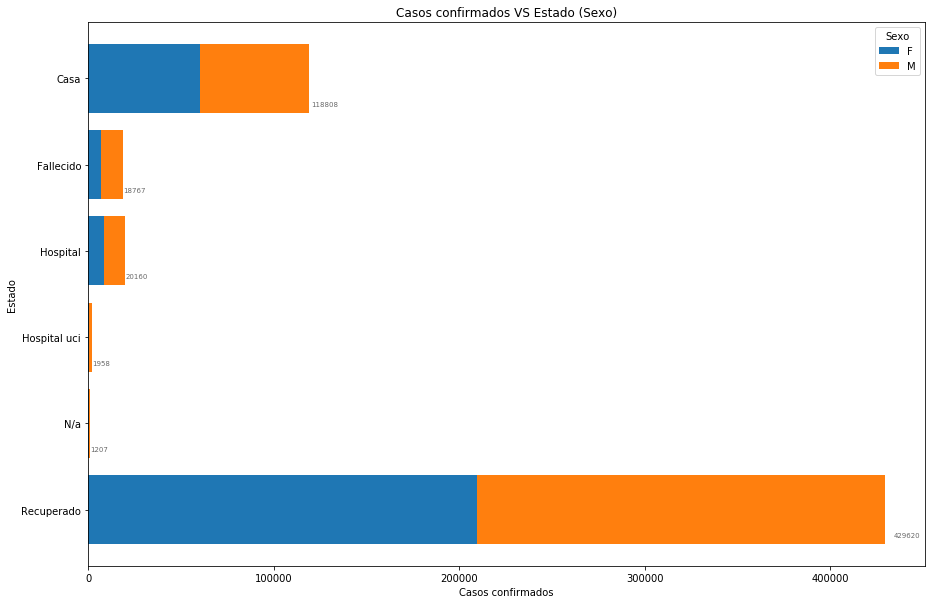

In [35]:
ax = data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [36]:
data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0)

Sexo               F       M
Estado                      
Casa           60557   58251
Fallecido       6714   12053
Hospital        8610   11550
Hospital uci     682    1276
N/a              521     686
Recuperado    209461  220159

### - Casos confirmados VS Tipo de contagio (Sexo)

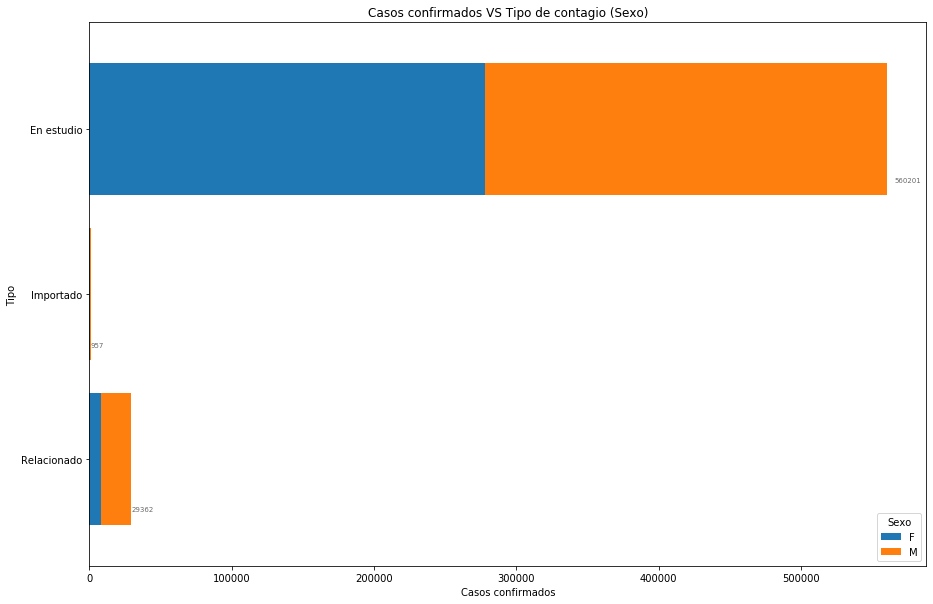

In [37]:
ax = data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo de contagio (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [38]:
data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0)

Sexo              F       M
Tipo                       
En estudio   278071  282130
Importado       450     507
Relacionado    8024   21338

### - Casos confirmados acumulado VS Fecha de diagnóstico (Clasificación de edad)

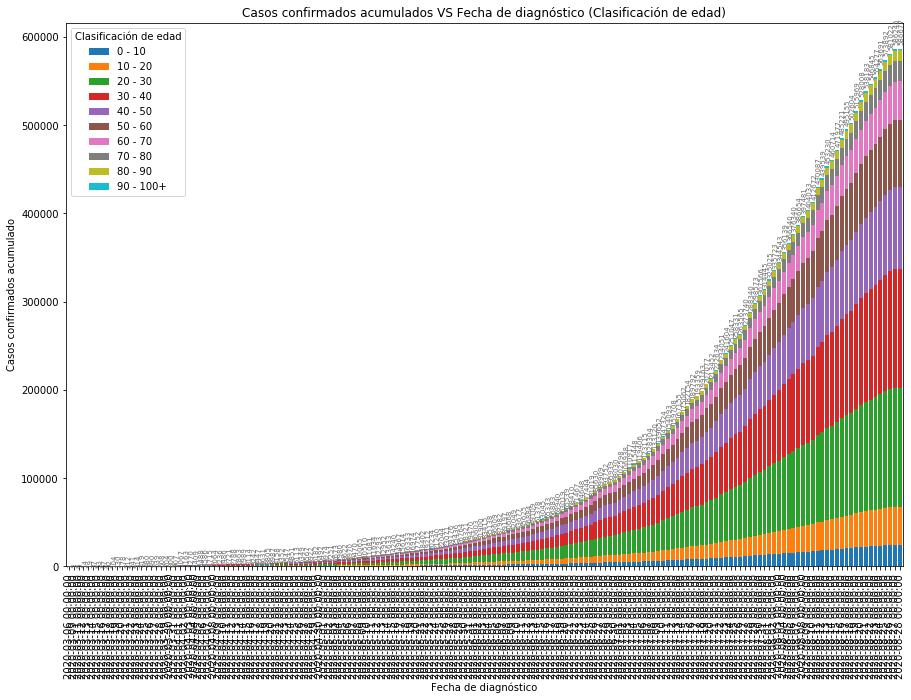

In [39]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [40]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-08-28              24183    43561   134752   134880    92915    76017   
2020-08-27              24161    43534   134657   134788    92841    75961   
2020-08-26              23947    43183   133465   133635    92008    75293   
2020-08-25              23694    42641   131920   132018    90888    74375   
2020-08-24              23326    41980   129603   129639    89228    73014   
2020-08-23              22969    41284   127423   127521    87755    71795   
2020-08-22              22662    40681   125636   125788    86654    70818   
2020-08-21              22345    40027   123643   123727    85349    69722   
2020-08-20              21929    39291   121219   121417    83740    68391   
2020-08-19              21449    38440   118580   118711    81827    66784   
2020-08-18              20821    37462   115576   115718    79637    65092   
2020-08-17              20569    36953   113928   114031    78446    64072   
2020-08-16              20056    36198   111726   111943    76861    62742   
2020-08-15              19441    35064   108781   109053    74756    61004   
2020-08-14              18943    34228   106189   106564    72986    59488   
2020-08-13              18690    33691   104473   104900    71777    58440   
2020-08-12              18067    32627   101376   101799    69590    56637   
2020-08-11              17724    31996    99307    99616    68087    55384   
2020-08-10              16930    30746    95198    95588    65254    53137   
2020-08-09              16599    30065    93247    93583    63900    52021   
2020-08-08              16354    29638    91739    92155    62818    51139   
2020-08-07              15939    28854    89301    89514    61113    49718   
2020-08-06              15525    28084    86941    87081    59475    48382   
2020-08-05              15076    27340    84763    84842    57906    47108   
2020-08-04              14650    26614    82379    82434    56219    45743   
2020-08-03              14161    25796    79721    79724    54316    44159   
2020-08-02              13837    25187    77722    77674    52969    42941   
2020-08-01              13394    24467    75311    75279    51162    41440   
2020-07-31              12980    23612    72758    72770    49541    40097   
2020-07-30              12707    23155    71228    71133    48366    39248   
2020-07-29              12363    22442    69046    69001    47040    38072   
2020-07-28              11981    21696    66621    66527    45354    36827   
2020-07-27              11352    20560    63295    63239    43037    34894   
2020-07-26              10966    19838    60907    60855    41367    33681   
2020-07-25              10755    19513    59718    59628    40553    33000   
2020-07-24              10471    19029    58081    57924    39387    32010   
2020-07-23              10150    18308    55876    55635    37910    30776   
2020-07-22               9873    17792    54192    53887    36709    29786   
2020-07-21               9467    16945    51471    51298    34923    28241   
2020-07-20               9107    16318    49307    49117    33440    27089   
2020-07-19               8829    15858    47952    47657    32370    26260   
2020-07-18               8516    15198    46118    45801    31059    25278   
2020-07-17               8294    14856    44824    44385    30102    24526   
2020-07-16               8171    14637    44022    43524    29555    24072   
2020-07-15               7829    14126    42309    41712    28302    23050   
2020-07-14               7534    13590    40701    40098    27171    22116   
2020-07-13               7238    13006    38833    38219    25894    21140   
2020-07-12               6983    12517    37050    36504    24680    20152   
2020-07-11               6742    12092    35739    35231    23766    19410   
2020-07-10            

### - Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)

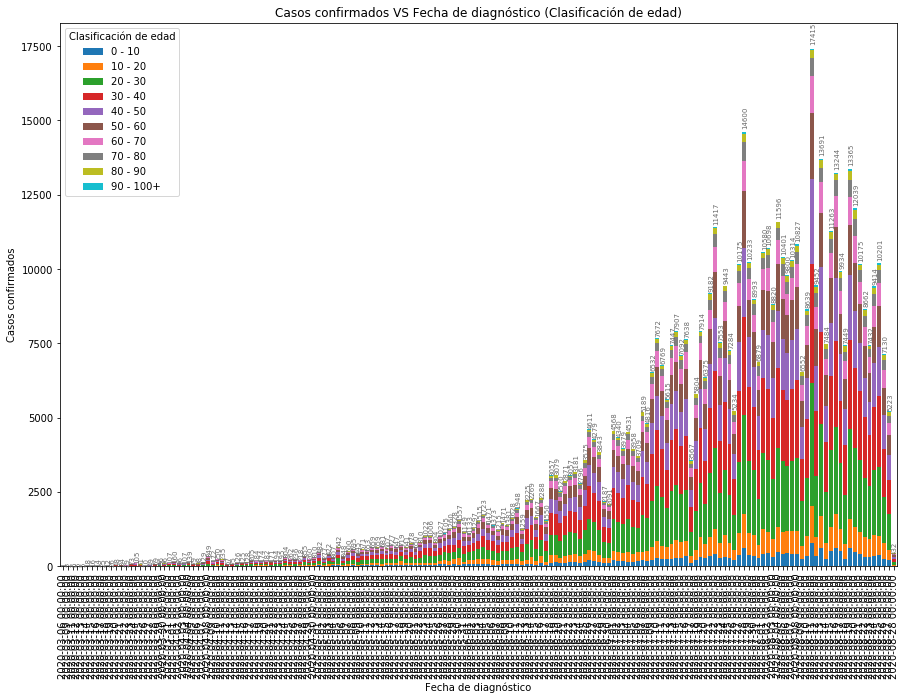

In [41]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [42]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-08-28                 22       27       95       92       74       56   
2020-08-27                214      351     1192     1153      833      668   
2020-08-26                253      542     1545     1617     1120      918   
2020-08-25                368      661     2317     2379     1660     1361   
2020-08-24                357      696     2180     2118     1473     1219   
2020-08-23                307      603     1787     1733     1101      977   
2020-08-22                317      654     1993     2061     1305     1096   
2020-08-21                416      736     2424     2310     1609     1331   
2020-08-20                480      851     2639     2706     1913     1607   
2020-08-19                628      978     3004     2993     2190     1692   
2020-08-18                252      509     1648     1687     1191     1020   
2020-08-17                513      755     2202     2088     1585     1330   
2020-08-16                615     1134     2945     2890     2105     1738   
2020-08-15                498      836     2592     2489     1770     1516   
2020-08-14                253      537     1716     1664     1209     1048   
2020-08-13                623     1064     3097     3101     2187     1803   
2020-08-12                343      631     2069     2183     1503     1253   
2020-08-11                794     1250     4109     4028     2833     2247   
2020-08-10                331      681     1951     2005     1354     1116   
2020-08-09                245      427     1508     1428     1082      882   
2020-08-08                415      784     2438     2641     1705     1421   
2020-08-07                414      770     2360     2433     1638     1336   
2020-08-06                449      744     2178     2239     1569     1274   
2020-08-05                426      726     2384     2408     1687     1365   
2020-08-04                489      818     2658     2710     1903     1584   
2020-08-03                324      609     1999     2050     1347     1218   
2020-08-02                443      720     2411     2395     1807     1501   
2020-08-01                414      855     2553     2509     1621     1343   
2020-07-31                273      457     1530     1637     1175      849   
2020-07-30                344      713     2182     2132     1326     1176   
2020-07-29                382      746     2425     2474     1686     1245   
2020-07-28                629     1136     3326     3288     2317     1933   
2020-07-27                386      722     2388     2384     1670     1213   
2020-07-26                211      325     1189     1227      814      681   
2020-07-25                284      484     1637     1704     1166      990   
2020-07-24                321      721     2205     2289     1477     1234   
2020-07-23                277      516     1684     1748     1201      990   
2020-07-22                406      847     2721     2589     1786     1545   
2020-07-21                360      627     2164     2181     1483     1152   
2020-07-20                278      460     1355     1460     1070      829   
2020-07-19                313      660     1834     1856     1311      982   
2020-07-18                222      342     1294     1416      957      752   
2020-07-17                123      219      802      861      547      454   
2020-07-16                342      511     1713     1812     1253     1022   
2020-07-15                295      536     1608     1614     1131      934   
2020-07-14                296      584     1868     1879     1277      976   
2020-07-13                255      489     1783     1715     1214      988   
2020-07-12                241      425     1311     1273      914      742   
2020-07-11                251      448     1631     1631     1085      857   
2020-07-10            

### - Casos confirmados VS Estado (Clasificación de edad)

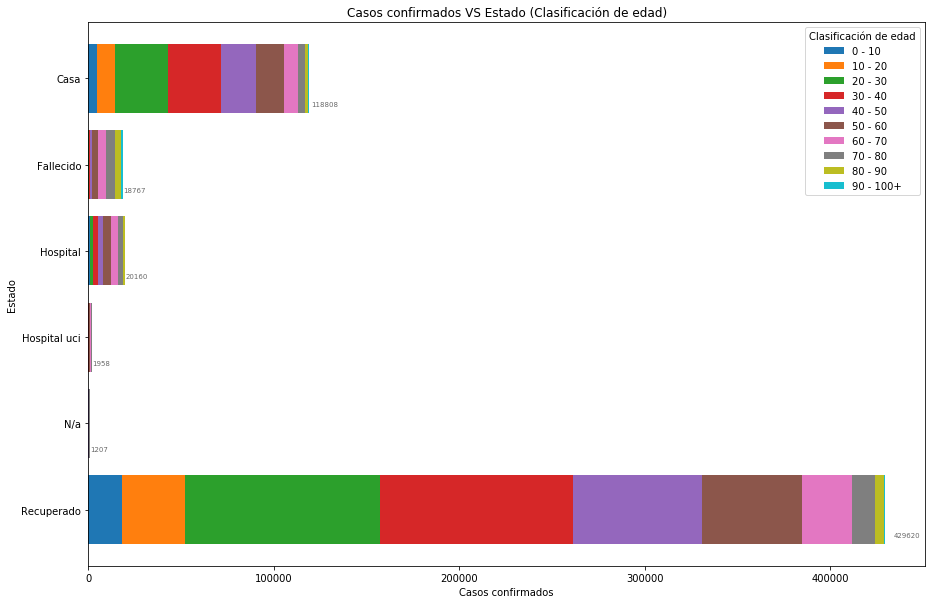

In [43]:
ax = data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [44]:
data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Estado                                                                       
Casa                     5051     9383    28738    28253    19273    14986   
Fallecido                  32       30      244      616     1368     2832   
Hospital                  854      426     1638     2410     2849     4079   
Hospital uci               47       29       84      190      296      486   
N/a                        30       20       53       43       91      145   
Recuperado              18304    33949   104906   104295    69603    53960   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Estado                                                       
Casa                      7568     3637     1591        328  
Fallecido                 4540     4781     3524        800  
Hospital                  3839     2617     1262        186  
Hospital uci               455      288       76          7  
N/a                        249      282      235         59  
Recuperado               26936    12139     4754        774

### - Casos confirmados VS Tipo de contagio (Clasificación de edad)

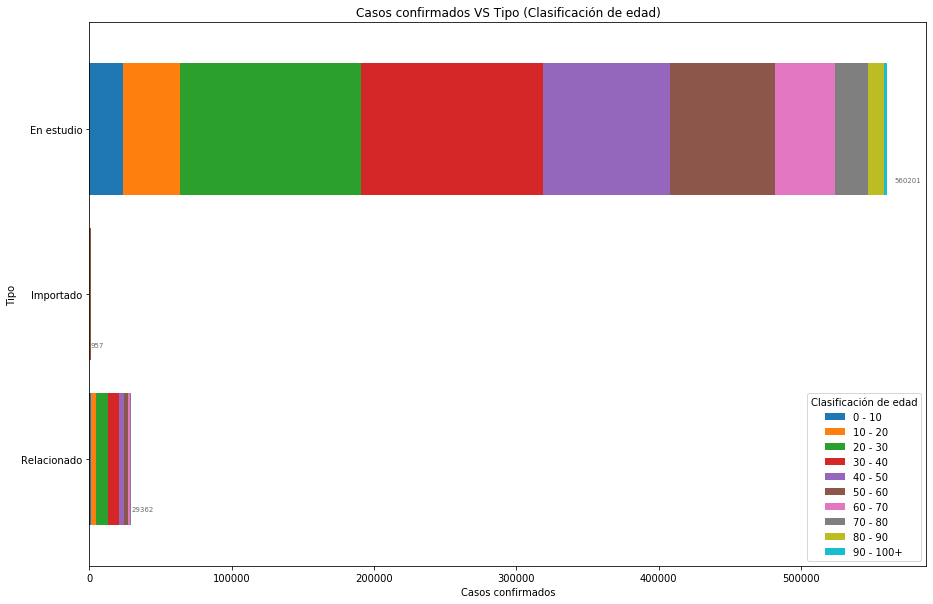

In [45]:
ax = data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [46]:
data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Tipo                                                                         
En estudio              23321    40073   127094   127966    89561    73784   
Importado                   5       37      239      222      169      144   
Relacionado               992     3727     8330     7619     3750     2560   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Tipo                                                         
En estudio               42175    23115    11053       2059  
Importado                   95       36        9          1  
Relacionado               1317      593      380         94

## #StayHome 🏠 #QuédateEnCasa
## #WearMask 😷 #UsaMascarilla 

### Creado con ❤️ por <a href='https://github.com/jlcadavid'>@jlcadavid</a>